Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.utils import decor_train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [3]:
args = argparse.Namespace(lr=0.0, kappa=1e-2, decor_lr=1e-2, epochs=20)

model = Decorrelation(784, bias=False, kappa=args.kappa).to(device)

lossfun = lambda x, y: nn.Parameter(torch.zeros(1, device=device, dtype=float), requires_grad=True)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 0.000000	decorrelation loss: 2023651.625000
epoch 1  	time:0.353 s	bp loss: 0.000000	decorrelation loss: 285334.062500
epoch 2  	time:0.327 s	bp loss: 0.000000	decorrelation loss: 24247.576172
epoch 3  	time:0.299 s	bp loss: 0.000000	decorrelation loss: 13905.796875
epoch 4  	time:0.333 s	bp loss: 0.000000	decorrelation loss: 10337.346680
epoch 5  	time:0.472 s	bp loss: 0.000000	decorrelation loss: 8417.177734
epoch 6  	time:0.340 s	bp loss: 0.000000	decorrelation loss: 7085.079590
epoch 7  	time:0.340 s	bp loss: 0.000000	decorrelation loss: 6046.424316
epoch 8  	time:0.312 s	bp loss: 0.000000	decorrelation loss: 5455.404297
epoch 9  	time:0.353 s	bp loss: 0.000000	decorrelation loss: 4950.171387
epoch 10 	time:0.307 s	bp loss: 0.000000	decorrelation loss: 4488.438477
epoch 11 	time:0.306 s	bp loss: 0.000000	decorrelation loss: 4183.062500
epoch 12 	time:0.324 s	bp loss: 0.000000	decorrelation loss: 3895.361328
epoch 13 	time:0.311 s	bp loss: 0.000000	de

layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.14



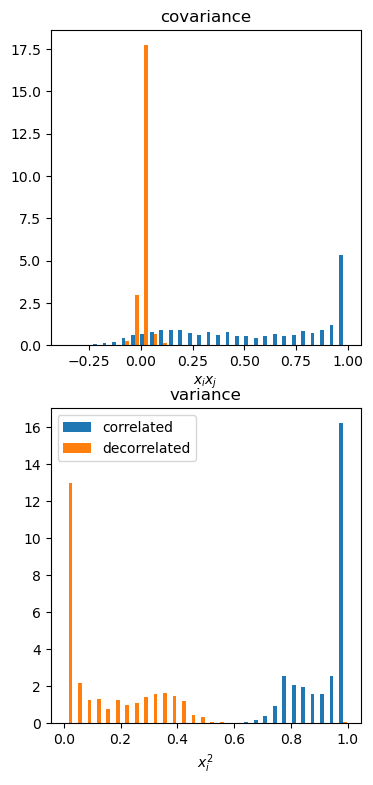

In [4]:
init_model = Decorrelation(784, bias=False, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device)

In [5]:
args = argparse.Namespace(lr=1e-4, kappa=1e-2, decor_lr=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 5.001185	decorrelation loss: 2024051.500000
epoch 1  	time:0.245 s	bp loss: 4.735165	decorrelation loss: 281147.656250
epoch 2  	time:0.249 s	bp loss: 4.491208	decorrelation loss: 24441.917969
epoch 3  	time:0.274 s	bp loss: 4.355632	decorrelation loss: 13984.295898
epoch 4  	time:0.431 s	bp loss: 4.258729	decorrelation loss: 10250.175781
epoch 5  	time:0.249 s	bp loss: 4.174423	decorrelation loss: 8280.869141
epoch 6  	time:0.244 s	bp loss: 4.107685	decorrelation loss: 6898.680664
epoch 7  	time:0.248 s	bp loss: 4.046644	decorrelation loss: 6118.406250
epoch 8  	time:0.251 s	bp loss: 3.982821	decorrelation loss: 5456.720215
epoch 9  	time:0.363 s	bp loss: 3.933910	decorrelation loss: 4995.050781
epoch 10 	time:0.295 s	bp loss: 3.882935	decorrelation loss: 4510.412598


layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.17



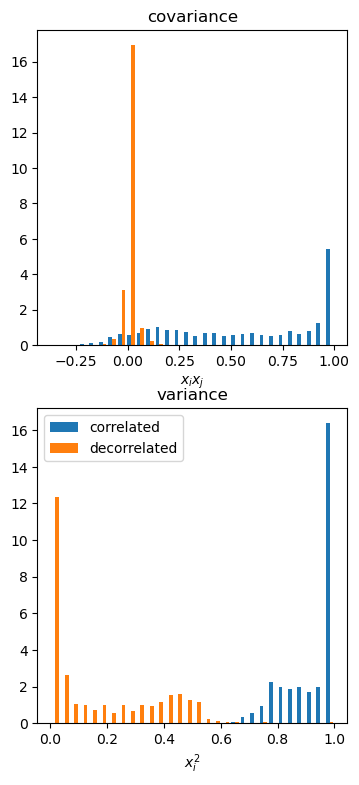

In [6]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device)

In [7]:
args = argparse.Namespace(lr=1e-3, kappa=1e-2, decor_lr=1e-2, epochs=30)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_bias=False, kappa=args.kappa),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_bias=False, kappa=args.kappa)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 2.534098	decorrelation loss: 2020864.500000
epoch 1  	time:0.275 s	bp loss: 2.030149	decorrelation loss: 284180.281250
epoch 2  	time:0.258 s	bp loss: 1.168110	decorrelation loss: 32211.898438
epoch 3  	time:0.260 s	bp loss: 0.747439	decorrelation loss: 22853.800781
epoch 4  	time:0.292 s	bp loss: 0.544967	decorrelation loss: 17328.664062
epoch 5  	time:0.272 s	bp loss: 0.439426	decorrelation loss: 13463.093750
epoch 6  	time:0.392 s	bp loss: 0.362960	decorrelation loss: 11131.095703
epoch 7  	time:0.258 s	bp loss: 0.317737	decorrelation loss: 9407.640625
epoch 8  	time:0.270 s	bp loss: 0.279998	decorrelation loss: 8222.495117
epoch 9  	time:0.285 s	bp loss: 0.244688	decorrelation loss: 7463.491699
epoch 10 	time:0.317 s	bp loss: 0.218400	decorrelation loss: 6657.041992
epoch 11 	time:0.321 s	bp loss: 0.198210	decorrelation loss: 6055.177734
epoch 12 	time:0.317 s	bp loss: 0.175090	decorrelation loss: 5549.571777
epoch 13 	time:0.261 s	bp loss: 0.160521	

layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.13

layer 2:

mean covariance before decorrelation: 0.05
mean variance before decorrelation: 0.15

mean covariance after decorrelation: 0.02
mean variance after decorrelation: 0.43



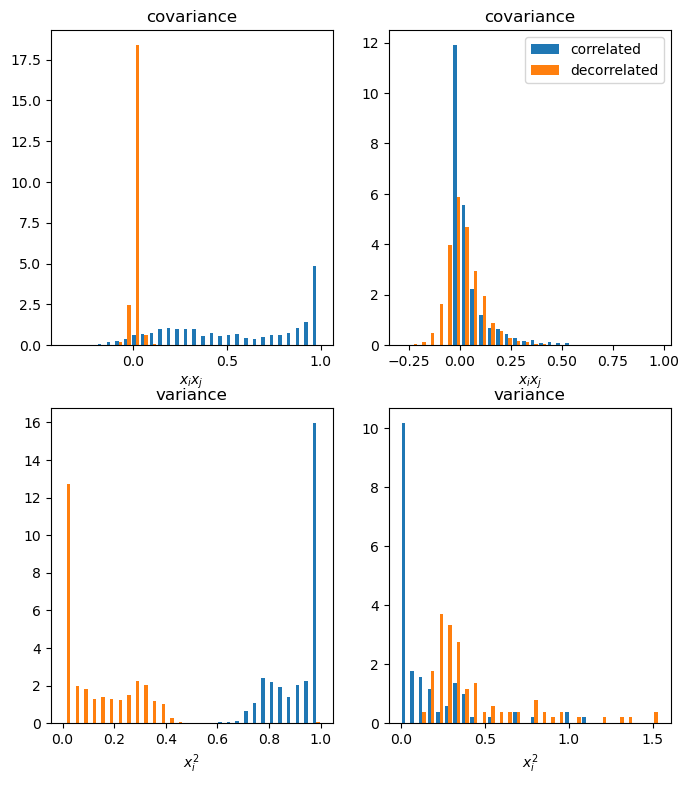

In [8]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device)